# Training a model on the 2022 Italian Grand Prix

In [1]:
import os   #used to create cache folder
import pandas as pd #table-like data
import numpy as np  #numbers and arrays
import matplotlib.pyplot as plt #charts
import seaborn as sns   #data visualization
import fastf1   #f1 library

from sklearn.model_selection import train_test_split    #splitting data
from sklearn.ensemble import RandomForestRegressor  #training model
from sklearn.metrics import mean_absolute_error, mean_squared_error #measuring accuracy

os.makedirs('data/fastf1_cache', exist_ok=True) #make sure cache dir exists
fastf1.Cache.enable_cache('data/fastf1_cache')  #use that cache


In [2]:
session = fastf1.get_session(2022, 'Monza', 'R')    #function that loads race session
session.load()  #parses data

core           INFO 	Loading data for Italian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '63', '55', '44', '11', '4', '10', '45', '24', '31', '47', '77', '22', '6', '20', '3', '18', '14', '5']


In [3]:
laps = session.laps #extracts data as pandas dataframe
laps.head() #shows first few rows

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 01:03:59.211000,VER,1,0 days 00:01:30.827000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:30.903000,...,True,Red Bull Racing,0 days 01:02:28.137000,2022-09-11 13:03:28.378,1,4.0,False,,False,False
1,0 days 01:05:25.612000,VER,1,0 days 00:01:26.401000,2.0,1.0,NaT,NaT,0 days 00:00:28.387000,0 days 00:00:29.504000,...,True,Red Bull Racing,0 days 01:03:59.211000,2022-09-11 13:04:59.452,1,3.0,False,,False,True
2,0 days 01:06:51.793000,VER,1,0 days 00:01:26.181000,3.0,1.0,NaT,NaT,0 days 00:00:28.205000,0 days 00:00:29.457000,...,True,Red Bull Racing,0 days 01:05:25.612000,2022-09-11 13:06:25.853,1,3.0,False,,False,True
3,0 days 01:08:17.575000,VER,1,0 days 00:01:25.782000,4.0,1.0,NaT,NaT,0 days 00:00:27.936000,0 days 00:00:29.170000,...,True,Red Bull Racing,0 days 01:06:51.793000,2022-09-11 13:07:52.034,1,3.0,False,,False,True
4,0 days 01:09:43.087000,VER,1,0 days 00:01:25.512000,5.0,1.0,NaT,NaT,0 days 00:00:27.904000,0 days 00:00:29.341000,...,True,Red Bull Racing,0 days 01:08:17.575000,2022-09-11 13:09:17.816,1,2.0,False,,False,True


In [4]:
clean_laps = laps[  #filter out in/out laps and timing errors
    (laps.get('IsAccurate', True)) &
    (laps['PitOutTime'].isna()) &
    (laps['PitInTime'].isna())
]

selected_cols = [   #keep useful stuff
    'Driver', 'Team', 'LapNumber', 'Stint', 'Compound',
    'TyreLife', 'LapTime'
]

clean_laps = clean_laps[selected_cols].dropna() #drop null rows
clean_laps['LapTimeSeconds'] = clean_laps['LapTime'].dt.total_seconds() #convert lap time to seconds



In [5]:
model_data = clean_laps.copy()  #make copy of data for modeling
#convert strings to codes for model
model_data['Compound'] = model_data['Compound'].astype('category').cat.codes
model_data['Team'] = model_data['Team'].astype('category').cat.codes
model_data['Driver'] = model_data['Driver'].astype('category').cat.codes

#x = inputs, y = lap time in seconds (what we're predicting)
features = ['Compound', 'TyreLife', 'Stint', 'Team', 'Driver']
X = model_data[features]
y = model_data['LapTimeSeconds']

#train 80%, test 20%
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Random forest model

In [6]:
model = RandomForestRegressor(n_estimators=100, random_state=42)    #create random forest model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)  #predict lap times

MAE: 0.299 seconds
RMSE: 0.421 seconds


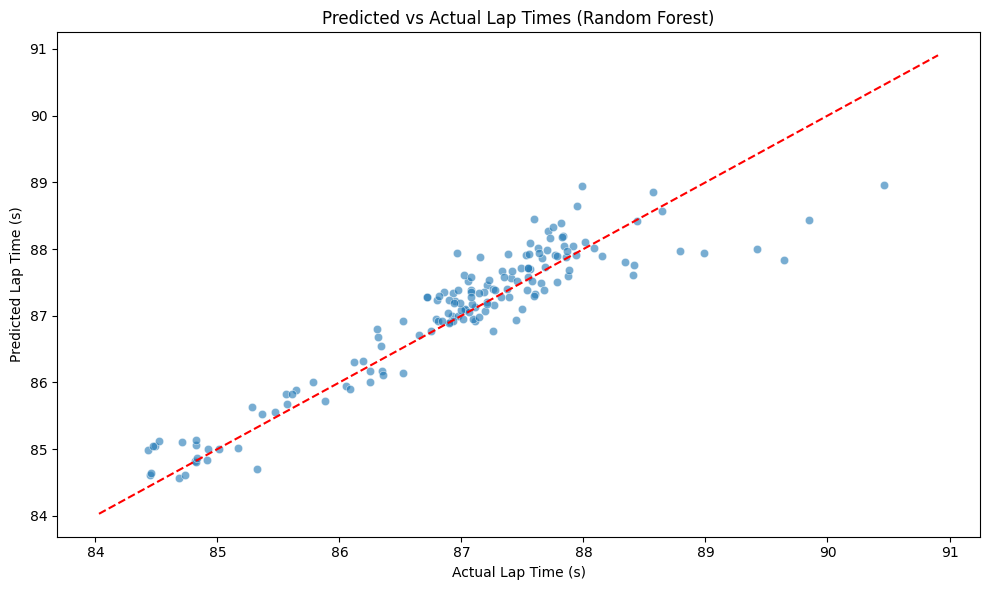

In [7]:
from math import sqrt

mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.3f} seconds")
print(f"RMSE: {rmse:.3f} seconds")

#plot predicted vs actual
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel("Actual Lap Time (s)")
plt.ylabel("Predicted Lap Time (s)")
plt.title("Predicted vs Actual Lap Times (Random Forest)")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # 1:1 line
plt.tight_layout()
plt.show()


## vs. XGBoost

In [8]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"[XGBoost] MAE: {mae_xgb:.3f} seconds")
print(f"[XGBoost] RMSE: {rmse_xgb:.3f} seconds")


[XGBoost] MAE: 0.321 seconds
[XGBoost] RMSE: 0.453 seconds


In [9]:
os.makedirs('models', exist_ok=True)
import joblib
joblib.dump(xgb_model, 'models/xgb_laptime_model.pkl')


['models/xgb_laptime_model.pkl']

In [10]:
import sys
sys.path.append('../src')  #so python can find sim

from simulator import simulate_strategy

In [18]:
total_time = simulate_strategy(
    compounds=['SOFT', 'MEDIUM', 'SOFT'],
    stint_lengths=[21, 28, 17],
    model=xgb_model,
    driver_id=3,
    team_id=1
)

print(f"Total predicted race time: {total_time:.1f} seconds")


Total predicted race time: 5770.1 seconds
